## Zebra - Stripes Sanity Check

Steps to follow.

1. Get the pre-trained VGG model on ImageNET
2. Get images of Zebra stripes and other stripes from Google.
3. Get acts and compute the CAV.
4. Take the directional derivative and check the score for both.

In [247]:
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline

In [248]:
datapath = '/Users/Janjua/Desktop/QCRI/Work/zebra_stripes_data/'
concepts = ['zebra_stripes', 'tiger_stripes']
classes = {'zebra_stripes': 1 , 'tiger_stripes': 0}

In [249]:
list_of_images = []
list_of_labels = []

for concept in concepts:
    for ix, imgp in tqdm(enumerate(glob(datapath + concept + '/*.jpg'))):
        label = imgp.split('/')[-2]
        img = cv2.imread(imgp)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        list_of_images.append(img)
        list_of_labels.append(classes[label]) 

79it [00:00, 569.89it/s]
79it [00:00, 590.69it/s]


In [250]:
print(len(list_of_images), len(list_of_labels))

158 158


Text(0.5, 1.0, 'Zebra Stripes')

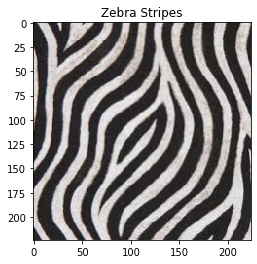

In [251]:
sample_img = list_of_images[3]
sample_labels = list_of_labels[3]
plt.imshow(sample_img)
plt.title('Zebra Stripes')

In [252]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [253]:
def get_VGG_features(img):
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    fts = model.predict(img_data)
    fts_np = np.array(fts)
    return fts_np

In [254]:
list_of_features, concept_labels = [], []
for ix, val in tqdm(enumerate(list_of_images)):
    fts = get_VGG_features(val)
    lbl = list_of_labels[ix]
    list_of_features.append(np.squeeze(fts))
    concept_labels.append(lbl)

158it [00:27,  5.74it/s]


In [430]:
base_classes = ['tiger']
base_classes_dict = {"zebra": 1, "tiger": 0}
list_of_base_img_fts, list_of_base_labels = [], []
base_imgs = []

def load_base_images():
    """
    Images of Zebra/Tiger - to take directional derivative with.
    """
    for base in base_classes:
        for ix, imgp in tqdm(enumerate(glob(datapath + base + '/*.jpg'))):
            label = imgp.split('/')[-2]
            img = cv2.imread(imgp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224,224))
            base_imgs.append(img)
            fts = get_VGG_features(img)
            list_of_base_img_fts.append(np.squeeze(fts))
            list_of_base_labels.append(base_classes_dict[label])

In [431]:
load_base_images()

79it [00:11,  7.16it/s]


1.  list_of_base_img_fts -> features of Zebra, Tiger
2.  list_of_features -> features of stripes of both

In [432]:
fts_np = np.array(list_of_features)
fts_base_np = np.array(list_of_base_img_fts)
lbls_np = np.array(list_of_labels)
lbls_base_np = np.array(list_of_base_labels)

In [433]:
print(fts_np.shape, lbls_np.shape)
print(fts_base_np.shape, lbls_base_np.shape)

(158, 7, 7, 512) (158,)
(79, 7, 7, 512) (79,)


In [434]:
fts_np = fts_np.reshape(-1, 7*7*512)
fts_base_np = fts_base_np.reshape(-1, 7*7*512)

In [435]:
print(fts_np.shape, lbls_np.shape)
print(fts_base_np.shape, lbls_base_np.shape)

(158, 25088) (158,)
(79, 25088) (79,)


In [436]:
X_train, X_test, y_train, y_test = train_test_split(fts_np, lbls_np, test_size=0.33, random_state=42)

In [437]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [438]:
y_test_pred = clf.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.8679245283018868

In [439]:
if len(clf.coef_) == 1:
    # if there were only two labels, the concept is assigned to label 0 by
    # default. So we flip the coef_ to reflect this.
    cavs = [-1 * clf.coef_[0], clf.coef_[0]]
else:
    cavs = [c for c in clf.coef_]

In [440]:
def get_direction(concept):
    return cavs[concepts.index(concept)]

In [453]:
direc = get_direction('tiger_stripes')

In [454]:
direc

array([-1.01161836e-03, -7.03371240e-06,  3.20994561e-05, ...,
       -4.98707030e-04,  5.51475570e-05, -2.48712945e-04])

In [455]:
def compute_direc_derivative(x,y):
    a = np.dot(x, y)
    return a < 0

In [456]:
scores = []
count = 0

for i, ix in enumerate(fts_base_np):
    lab = lbls_base_np[i]
    dydx = compute_direc_derivative(ix, direc)
    if dydx:
        count += 1
        
tcav = float(count) / float(len(fts_base_np))
print('TCAV: ', tcav)
neg = 1 - tcav

TCAV:  0.9873417721518988


In [457]:
tcavs = {'tcav': tcav, 'other': neg}
print(tcavs)

{'tcav': 0.9873417721518988, 'other': 0.012658227848101222}


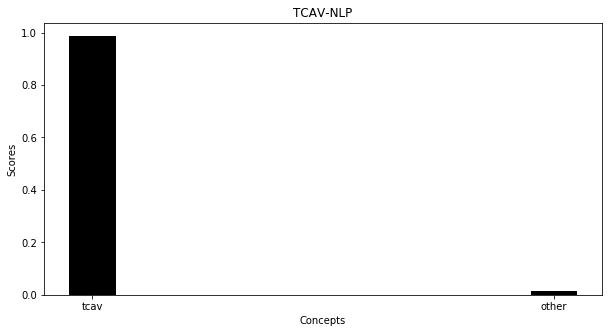

In [458]:
fig = plt.figure(figsize = (10, 5)) 
  
plt.bar(list(tcavs.keys()), list(tcavs.values()), color ='black', width = 0.1)

plt.xlabel("Concepts")
plt.ylabel("Scores")
plt.title("TCAV-NLP")
plt.show()

## Visual Details - Concepts, Images and CAVs with Examples

### Example # 01: Zebra

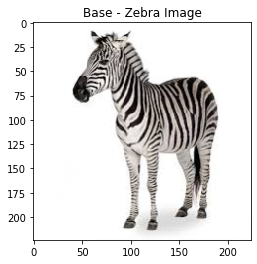

In [272]:
base_img = base_imgs[3]
plt.imshow(base_img)
plt.title('Base - Zebra Image')
plt.show()

#### Important Question to Ask

1. Is the concept of `stripes` used to classify this image of Zebra?

Text(0.5, 1.0, 'Zebra Stripes')

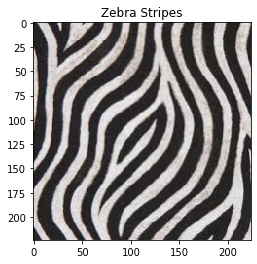

In [273]:
sample_img = list_of_images[3]
sample_labels = list_of_labels[3]
plt.imshow(sample_img)
plt.title('Zebra Stripes')

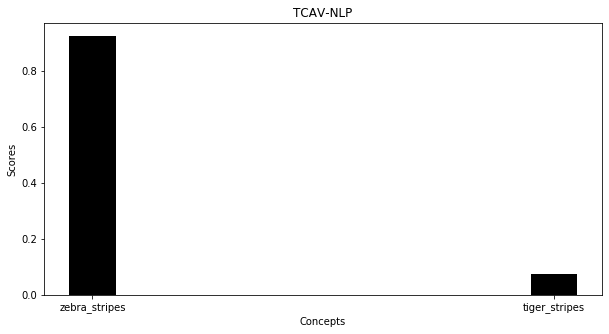

In [274]:
fig = plt.figure(figsize = (10, 5)) 
  
plt.bar(list(tcavs.keys()), list(tcavs.values()), color ='black', width = 0.1)

plt.xlabel("Concepts")
plt.ylabel("Scores")
plt.title("TCAV-NLP")
plt.show()

### Example # 02: Tiger

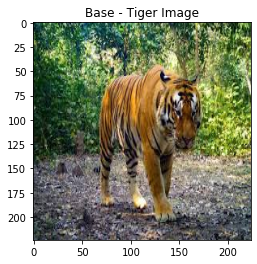

In [237]:
base_img = base_imgs[3]
plt.imshow(base_img)
plt.title('Base - Tiger Image')
plt.show()

### Important Question to Ask

1. Is the concept of `stripes` used to classify this image of Tiger?

Text(0.5, 1.0, 'Zebra Stripes')

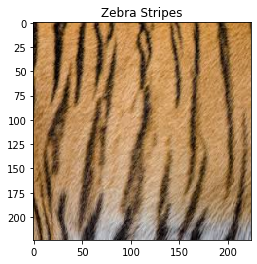

In [245]:
sample_img = list_of_images[144]
sample_labels = list_of_labels[144]
plt.imshow(sample_img)
plt.title('Tiger Stripes')

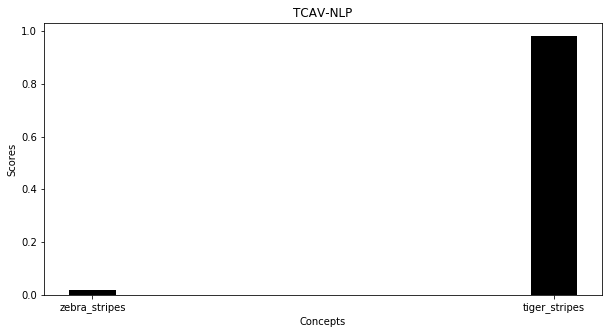

In [246]:
fig = plt.figure(figsize = (10, 5)) 
  
plt.bar(list(tcavs.keys()), list(tcavs.values()), color ='black', width = 0.1)

plt.xlabel("Concepts")
plt.ylabel("Scores")
plt.title("TCAV-NLP")
plt.show()